In [8]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
from nltk.translate.bleu_score import corpus_bleu
from nltk.util import ngrams
import numpy as np
from PIL import Image
import configparser

config = configparser.ConfigParser()
config.read("config.ini")

#importing local module 
from models.subclasses import *
from models.utilities import *
from models.predict import *
from models.train_utils import *


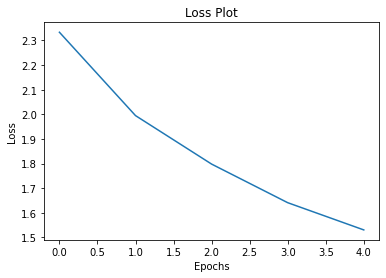

In [9]:
loss_plot = load_loss()
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [10]:
units = int(config['config']['units'])
embedding_dim = int(config['config']['embedding_dim'])

In [11]:
val_image_paths, image_path_to_caption = import_files(shuffle= False, method = "val")

val_captions = []
img_name_vector = []
for image_path in val_image_paths:
  caption_list = image_path_to_caption[image_path]
  val_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

100


In [23]:
_, _, vocabulary, _ = load_dataset()

In [13]:
word_to_index, index_to_word, tokenizer, cap_vector = tokenization(val_captions, max_length, 5000)

In [14]:
glove_path = "./dataset/glove.6B/glove.6B.50d.txt"

embeddings_index = {}
with open(glove_path) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [24]:
# vocabulary = tokenizer.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

In [25]:
num_tokens = len(vocabulary) + 2
embedding_dim = 50
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 2141 words (833 misses)


In [26]:
encoder = CNN_Encoder(embedding_dim)
if use_glove:
    decoder = RNN_Decoder(embedding_dim, units, num_tokens, embedding_matrix)
else:
    decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size(), None)
image_features_extract_model = get_feature_extractor()

In [27]:
img_name_val, cap_val = split_data(img_name_vector, cap_vector ,
                                    image_features_extract_model, 1)

100%|██████████| 4/4 [00:00<00:00,  6.62it/s]


In [28]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
ckpt.restore(ckpt_manager.latest_checkpoint)

In [29]:
references = []

for i in range(len(img_name_val)):
    references.append(' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[i] if i not in [0]]).split('<start>')[1].split())

In [30]:
list_of_references = []

for i in range(0, len(img_name_val), 4):
    list_of_references.append([references[i:i+4]])

Real Caption: spectators enjoying a show of two men on four-wheelers. <end>
Prediction Caption: from [UNK] kites brown street. of [UNK] [UNK] with [UNK] either bathroom. of [UNK] and tree [UNK]
BLEU-1: 0.197229
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000


C:\Users\hazem\AppData\Roaming\Python\Python39\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\hazem\AppData\Roaming\Python\Python39\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\hazem\AppData\Roaming\Python\Python39\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using 

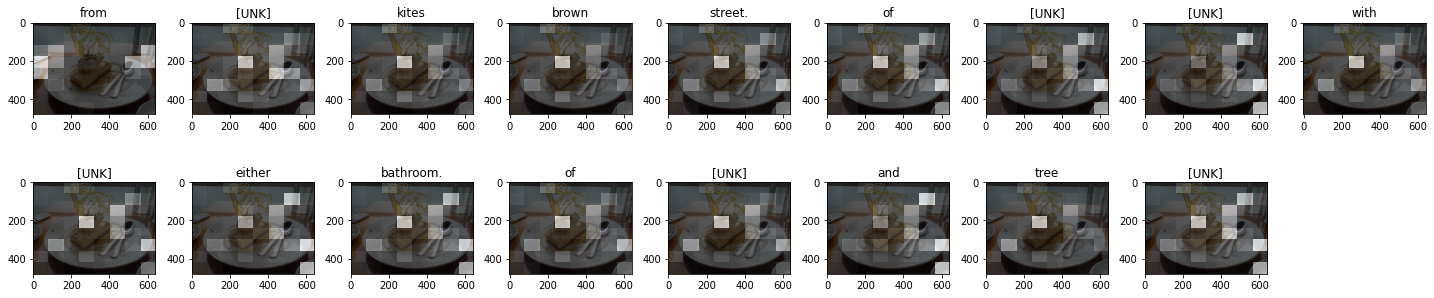

In [31]:
# captions on the test set
# rid = np.random.randint(0, len(img_name_val))
# image = img_name_val[rid]
num = 7

image = img_name_val[num]
# real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
#                          for i in cap_val[rid] if i not in [0]]).split()

result, attention_plot = evaluate(image, encoder, decoder, image_features_extract_model,
                                    word_to_index, index_to_word)

if result[-1] == "<end>":
    result.remove("<end>")
# if real_caption[0] == "<start>":
#     real_caption.remove("<start>")


list_of_hypotheses = [result]

print('Real Caption:', ' '.join(references[int(num/4)]))
print('Prediction Caption:', ' '.join(result))
print('BLEU-1: %f' % corpus_bleu(list_of_references[num], list_of_hypotheses, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(list_of_references[num], list_of_hypotheses, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(list_of_references[num], list_of_hypotheses, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(list_of_references[num], list_of_hypotheses, weights=(0.25, 0.25, 0.25, 0.25)))
plot_attention(image, result, attention_plot)